In [14]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [15]:
d = os.getcwd()
print(d)
print(sys.path)

/home/ashutosh/Desktop/Uncomputation-Code/eval_notebooks
['/usr/lib/python310.zip', '../', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/ashutosh/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


In [16]:
valid_num_circuits = 10

In [17]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType

In [18]:
def random_quantum_circuit_large_distinct_nums(num_q, num_a) -> tuple[QuantumCircuit,int,int,int]:
    
    # num_q = random.randint(3,10)
    # num_a = random.randint(3,10)
    # num_g = random.randint(50, 100)
    # num_g = random.randint(10,50)
    num_g = 25

    cc_gates = 0
    ca_gates = 0
    ac_gates = 0
    aa_gates = 0
    
    in_q = QuantumRegister(num_q, name='cq')
    an_q = QuantumRegister(num_a, name='aq')
    
    circuit = QuantumCircuit(in_q, an_q)

    for q in in_q:
        circuit.x(q)
        circuit.h(q)
    
    for i in tqdm(range(num_g), desc=f'Building Random Quantum Circuit with {num_q}q, {num_a}a, {num_g}g'):

        control_q = in_q
        target_q = in_q

        change_target_controls = random.random()

        if change_target_controls > 0.8: # Input acts on Input only    
            control_q = an_q
            target_q = an_q
            aa_gates += 1

        elif change_target_controls > 0.4: 
            # control_q = in_q
            if random.random() > 0.5:
                target_q = an_q
                ca_gates += 1
            else:
                control_q = an_q
                ac_gates += 1

        else:
            cc_gates += 1 
            

        num_controls = random.randrange(1, control_q.size)
        target = random.randrange(target_q.size) # Get target qubit
        controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        # target = random.randrange(target_q.size) # Get target qubit
        if control_q == target_q:
            target = random.randrange(target_q.size) # Get target qubit
            valid_controls = list(range(control_q.size))
            valid_controls.remove(target)
            controls = random.sample(valid_controls, num_controls)  # Get control qubit/s
        else:
            target = random.randrange(target_q.size) # Get target qubit
            controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        
        # print(num_controls, controls, target)
        circuit.mcx([control_q[cq] for cq in controls],target_q[target]) 

    # logger.info(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    # logger.info(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    print(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    print(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    
    return circuit, num_q, num_a, num_g

def get_eval_results(comp_circuit: QuantumCircuit, uncomp_circuit:QuantumCircuit, num_a):
    eq4_comp_statevector = get_statevector(comp_circuit)
    eq4_comp_prob_dist = get_probability_from_statevector(eq4_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_comp_prob_dist)}')

    eq5_comp_statevector = zero_ancillas_in_statevector(eq4_comp_statevector, num_a)
    eq5_comp_prob_dist = get_probability_from_statevector(eq5_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq5 Probability Distribution: \n{print_probs(eq5_comp_prob_dist)}')

    eq4_uncomp_statevector = get_statevector(uncomp_circuit)
    eq4_uncomp_prob_dist = get_probability_from_statevector(eq4_uncomp_statevector)
    # logger.info(f'{uncomp_type.capitalize()} Uncomp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_uncomp_prob_dist)}')

    distance_probs_eq5_4_comp = numpy.linalg.norm(eq5_comp_prob_dist - eq4_comp_prob_dist)
    distance_probs_eq5_4_uncomp = numpy.linalg.norm(eq4_uncomp_prob_dist - eq5_comp_prob_dist)
    
    distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp = numpy.round((distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp), decimals=10)

    return distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp, eq4_comp_prob_dist, eq5_comp_prob_dist, eq4_uncomp_prob_dist


    


In [19]:
class ProbDiffResults:
    def __init__(self):
        self.exhaustive_comp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq4 = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq5 = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)
        

        self.greedy_full_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)
        
        self.greedy_partial_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp_diff = numpy.zeros(valid_num_circuits)        
        self.greedy_partial_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

        self.regular_comp_diff = numpy.zeros(valid_num_circuits)
        self.regular_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.regular_eq4 = numpy.zeros(valid_num_circuits)
        self.regular_eq5 = numpy.zeros(valid_num_circuits)
        self.regular_uncomp = numpy.zeros(valid_num_circuits)

    def add_to_exhaustive(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.exhaustive_comp_diff[idx] = comp_diff
        self.exhaustive_uncomp_diff[idx] = uncomp_diff
        # self.exhaustive_eq4[idx] = eq4
        # self.exhaustive_eq5[idx] = eq5
        # self.exhaustive_uncomp[idx] = uncomp


    def add_to_greedy_partial(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_partial_comp_diff[idx] = comp_diff
        self.greedy_partial_uncomp_diff[idx] = uncomp_diff
        # self.greedy_partial_eq4[idx] = eq4
        # self.greedy_partial_eq5[idx] = eq5
        # self.greedy_partial_uncomp[idx] = uncomp
    
    def add_to_greedy_full(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_full_comp_diff[idx] = comp_diff
        self.greedy_full_uncomp_diff[idx] = uncomp_diff
        # self.greedy_full_eq4[idx] = eq4
        # self.greedy_full_eq5[idx] = eq5
        # self.greedy_full_uncomp[idx] = uncomp
    
    def add_to_regular(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.regular_comp_diff[idx] = comp_diff
        self.regular_uncomp_diff[idx] = uncomp_diff
        # self.regular_eq4[idx] = eq4
        # self.regular_eq5[idx] = eq5
        # self.regular_uncomp[idx] = uncomp

    def __str__(self):
        return f'''
                Exhaustive Comp Avg:\t\t{numpy.average(self.exhaustive_comp_diff)}
                Exhaustive UnComp Avg:\t\t{numpy.average(self.exhaustive_uncomp_diff)}
                Greedy Full Comp Avg:\t\t{numpy.average(self.greedy_full_comp_diff)}
                Greedy Full UnComp Avg:\t\t{numpy.average(self.greedy_full_uncomp_diff)}
                Greedy Partial Comp Avg:\t{numpy.average(self.greedy_partial_comp_diff)}
                Greedy Partial UnComp Avg:\t{numpy.average(self.greedy_partial_uncomp_diff)}
                Regular Comp Avg:\t\t{numpy.average(self.regular_comp_diff)}
                Regular UnComp Avg:\t\t{numpy.average(self.regular_uncomp_diff)}
                '''

        

In [20]:

def get_circuit_metrics(num_q, num_a, results:ProbDiffResults):
    print('****************************************************************************')
    for idx in range(valid_num_circuits):
        # if num_circuits > 0:

        #     logger.info(f'Generating Random Circuit {i}')
        #     # _circuit, num_q, num_a, num_g = random_quantum_circuit_basic()
        #     _circuit, num_q, num_a, num_g = random_quantum_circuit_large()

        # else:
        #     _circuit, num_q, num_a, num_g = simple_circuit_with_partial_uncomp()

        _circuit, num_q, num_a, num_g = random_quantum_circuit_large_distinct_nums(num_q,num_a)
            

        name_str = f'Circuit_{idx}'

        # _circuit.draw('mpl', 
        #                 filename=f'{eval_dir}/comp_circuit/{name_str}.png')
        
        # with open(f'{eval_dir}/comp_circuit_qpy/{name_str}.qpy', 'wb') as f:
        #     qpy.dump(_circuit, f)
        #     f.close()
        
        # logger.info(f'Building Random Circuit took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        # logger.info(f'Creating Circuit Graph of circuit {name_str}')
        ancillas_list = [breakdown_qubit(q)['label'] for q in _circuit.qubits][-num_a:]
        _circuit_graph = get_computation_graph(_circuit, ancillas_list)

        # graphviz_draw(_circuit_graph,
        #               node_attr_fn=node_attr,
        #               edge_attr_fn=edge_attr,
        #               filename=f'{eval_dir}/comp_circuit_graph/{name_str}.png')

        # logger.info(f'Building Circuit Graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        
        if rustworkx.digraph_find_cycle(_circuit_graph):
            # print(f'Computation Graph has cycles !!!!')
            # logger.error(f'Computation Circuit Graph for circuit {name_str} has cycles!!')
            for cycle in rustworkx.simple_cycles(_circuit_graph):
                print(cycle)
                # logger.error(f'Cycle in {name_str} : {cycle}')

        # logger.info(f'Checking for cycle in Comp Circuit Graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        
        _regular_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, ancillas_list)

        # logger.info(f'Adding Uncomputation to circuit graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()

        if has_cycle:
            # logger.warning(f'Trying to uncompute circuit {name_str} produces a cycle')

            # logger.info(f'Attempting to run exhaustive uncomp on {name_str}')
            largest_set = exhaustive_uncomputation_adding(_circuit_graph, ancillas_list)
            print(f'Largest Set of ancilla for {name_str} that can be uncomputed is {largest_set}')
            # logger.info(f'Time to find largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()
            _exhaustive_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, list(largest_set))
            if has_cycle:
                print(f'Exhaustive Uncomp of {name_str} still has cycle')
            
            # logger.info(f'Drawing Exhaustive Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_exhaustive_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/exhaustive_uncomp_graph/{name_str}.png')

            # logger.info(f'Adding Uncomp for largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()

            # logger.info(f'Building Exhaustive Uncomp Circuit for {name_str}')
            _exhaustive_uncomp_circuit = get_uncomp_circuit(_exhaustive_uncomp_circuit_graph)
            # _exhaustive_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/exhaustive_uncomp_circuit/{name_str}.png')

            # logger.info(f'Time to build uncomp circuit took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()

            
            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_exhaustive_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.EXHAUSTIVE)

            ex_vals = get_eval_results(_circuit, _exhaustive_uncomp_circuit, num_a)

            # print(f'Exhaustive Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
            
            results.add_to_exhaustive(*ex_vals, idx=idx)

            # with open(f'{eval_dir}/exhaustive_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_exhaustive_uncomp_circuit, f)
            #     f.close()
            

    # ***************************************************************************************************************#
            # logger.info(f'Attempting to run greedy uncomp on {name_str}')
            _greedy_uncomp_circuit_graph = greedy_uncomputation_full(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            # logger.info(f'Drawing Greedy Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_greedy_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/greedy_uncomp_graph/{name_str}.png')

            # logger.info(f'Building Greedy Uncomp Circuit for {name_str}')
            _greedy_uncomp_circuit = get_uncomp_circuit(_greedy_uncomp_circuit_graph)
            # _greedy_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/greedy_uncomp_circuit/{name_str}.png')


            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_greedy_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.GREEDY_FULL)
            
            gf_vals = get_eval_results(_circuit, _greedy_uncomp_circuit, num_a)
            
            results.add_to_greedy_full(*gf_vals, idx=idx)

            # print(f'Greedy-Full Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')

            # with open(f'{eval_dir}/greedy_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_greedy_uncomp_circuit, f)
            #     f.close()
            

    #**************************************************************************************************************#
            print(f'Comparing the uncomp circuit grapphs by greedy and exhaustive for {name_str}')
            if rustworkx.is_isomorphic(_greedy_uncomp_circuit_graph, _exhaustive_uncomp_circuit_graph,
                                        node_matcher=node_matcher, edge_matcher=edge_matcher):
                print(f'Both methods return the same circuit graphs')
                # metrics.greedy_and_exhaustive_return_same += 1
            else:
                print(f'Both methods return different circuit graphs')

    #**************************************************************************************************************#
            # logger.info(f'Attempting to run greedy partial uncomp on {name_str}')
            _greedy_partial_uncomp_circuit_graph = greedy_uncomputation_partial(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            # logger.info(f'Drawing Greedy Partial Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_greedy_partial_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/greedy_partial_uncomp_graph/{name_str}.png')

            # logger.info(f'Building Greedy Partial Uncomp Circuit for {name_str}')
            _greedy_partial_uncomp_circuit = get_uncomp_circuit(_greedy_partial_uncomp_circuit_graph)
            # _greedy_partial_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/greedy_partial_uncomp_circuit/{name_str}.png')

            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_greedy_partial_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.GREEDY_PARTIAL) 

            gp_vals = get_eval_results(_circuit, _greedy_partial_uncomp_circuit, num_a)
            
            results.add_to_greedy_partial(*gp_vals, idx=idx)
            # with open(f'{eval_dir}/greedy_partial_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_greedy_partial_uncomp_circuit, f)
            #     f.close()


            # print(f'Greedy-Partial Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
    #**************************************************************************************************************#
        else:
            # logger.info(f'Drawing Regular Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_regular_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/regular_uncomp_graph/{name_str}.png')
            
            # logger.info(f'Building Regular Uncomp Circuit for {name_str}')
            _uncomp_circuit = get_uncomp_circuit(_regular_uncomp_circuit_graph)
            # _uncomp_circuit.draw('mpl', filename=f'{eval_dir}/regular_uncomp_circuit/{name_str}.png')

            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.REGULAR)
            
            # metrics.can_be_regularly_uncomputed += 1
            reg_vals = get_eval_results(_circuit, _uncomp_circuit, num_a)
            
            results.add_to_regular(*reg_vals, idx=idx)
            # with open(f'{eval_dir}/regular_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_uncomp_circuit, f)
            #     f.close()

            # print(f'Regular Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
    return results


In [21]:
%%capture eval_circs_out
# ^ To restrict output

num_q = 5
results_dict = {}
for idx in range(3,10):
    results = ProbDiffResults()
    filled_results = get_circuit_metrics(num_q, idx, results)
    print(filled_results)
    results_dict.update({idx: filled_results})
    

In [22]:
x_axis = []
ex_comp_avg = []
ex_uncomp_avg = []
gf_comp_avg = []
gf_uncomp_avg = []
gp_comp_avg = []
gp_uncomp_avg = []

'''
self.exhaustive_comp = numpy.zeros(valid_num_circuits)
self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)

self.greedy_full_comp = numpy.zeros(valid_num_circuits)
self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)

self.greedy_partial_comp = numpy.zeros(valid_num_circuits)
self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

self.regular_comp = numpy.zeros(valid_num_circuits)
self.regular_uncomp = numpy.zeros(valid_num_circuits)

'''

for i,x in results_dict.items():
    print(i)
    print(x)
    print('-------------------------------')
    x_axis.append(i)
    ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
    ex_uncomp_avg.append(numpy.average(x.exhaustive_uncomp_diff))
    gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
    gf_uncomp_avg.append(numpy.average(x.greedy_full_uncomp_diff))
    gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
    gp_uncomp_avg.append(numpy.average(x.greedy_partial_uncomp_diff))

3

                Exhaustive Comp Avg:		0.18890399256
                Exhaustive UnComp Avg:		0.18835149792
                Greedy Full Comp Avg:		0.18890399256
                Greedy Full UnComp Avg:		0.18835149792
                Greedy Partial Comp Avg:	0.18890399256
                Greedy Partial UnComp Avg:	0.18278203607000001
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
-------------------------------
4

                Exhaustive Comp Avg:		0.20485987538
                Exhaustive UnComp Avg:		0.20290086426
                Greedy Full Comp Avg:		0.20485987538
                Greedy Full UnComp Avg:		0.20485987538
                Greedy Partial Comp Avg:	0.20485987538
                Greedy Partial UnComp Avg:	0.20431791633000002
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
-------------------------------
5

                Exhaustive Comp Avg:		0.20110348358
                E

In [23]:
print(x_axis)
print(ex_comp_avg)
print(ex_uncomp_avg)
print(gf_comp_avg)
print(gf_uncomp_avg)
print(gp_comp_avg)
print(gp_uncomp_avg)

[3, 4, 5, 6, 7, 8, 9]
[np.float64(0.18890399256), np.float64(0.20485987538), np.float64(0.20110348358), np.float64(0.18252688287000002), np.float64(0.19234919448), np.float64(0.18193431341), np.float64(0.1982317124)]
[np.float64(0.18835149792), np.float64(0.20290086426), np.float64(0.1981910698), np.float64(0.17973244433000002), np.float64(0.18474337983000003), np.float64(0.1748736158), np.float64(0.18455762019000002)]
[np.float64(0.18890399256), np.float64(0.20485987538), np.float64(0.20110348358), np.float64(0.18252688287000002), np.float64(0.19234919448), np.float64(0.18193431341), np.float64(0.1982317124)]
[np.float64(0.18835149792), np.float64(0.20485987538), np.float64(0.1981910698), np.float64(0.18194649864), np.float64(0.18642915881000002), np.float64(0.17583828536), np.float64(0.18578425499)]
[np.float64(0.18890399256), np.float64(0.20485987538), np.float64(0.20110348358), np.float64(0.18252688287000002), np.float64(0.19234919448), np.float64(0.18193431341), np.float64(0.19823

In [24]:
import matplotlib.pyplot as plt

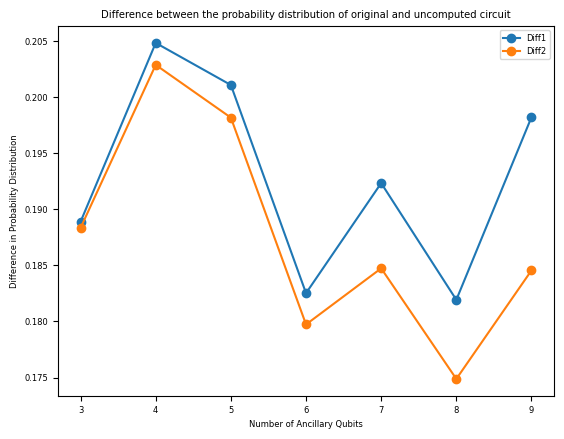

In [25]:
plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Diff1')
plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Diff2')
# plt.setp(lines)
plt.title(f'Difference between the probability distribution of original and uncomputed circuit')
plt.xlabel('Number of Ancillary Qubits')
plt.ylabel('Difference in Probability Distribution')
plt.legend()
plt.show()

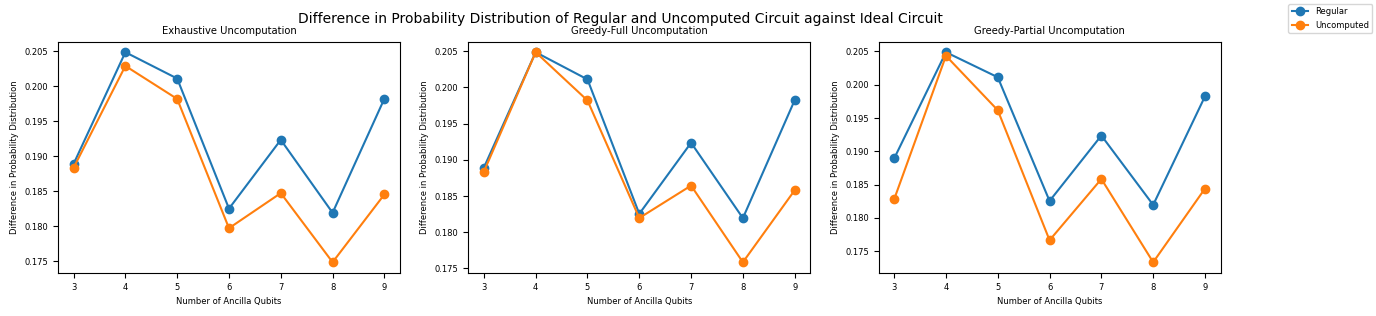

In [26]:
plt.rcParams['font.size'] = 6
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))

ax1.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Regular')
ax1.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Uncomputed')
ax1.set_title('Exhaustive Uncomputation')
ax1.set_xlabel('Number of Ancilla Qubits')
ax1.set_ylabel('Difference in Probability Distribution')

ax2.plot(x_axis, gf_comp_avg, marker='o', linestyle='-')
ax2.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-')
ax2.set_title('Greedy-Full Uncomputation')
ax2.set_xlabel('Number of Ancilla Qubits')
ax2.set_ylabel('Difference in Probability Distribution')

ax3.plot(x_axis, gp_comp_avg, marker='o', linestyle='-')
ax3.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-')
ax3.set_title('Greedy-Partial Uncomputation')
ax3.set_xlabel('Number of Ancilla Qubits')
ax3.set_ylabel('Difference in Probability Distribution')

fig.suptitle('Difference in Probability Distribution of Regular and Uncomputed Circuit against Ideal Circuit', fontsize=10)
fig.legend()

plt.show()
